Names: Guy Cohen, Shahar Amram

IDs: 206463606, 205457898

### The objective of this assignment is to develop a predictive model using the AdaBoost algorithm to determine whether a patient has heart disease or not. We have a dataset containing various features related to patients, and based on these features, we will train an AdaBoost classifier to make accurate predictions.

In [405]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Load the csv file.
def load_data():
    data = pd.read_csv("heart_disease.csv")
    # Shuffle the data.
    shuffled_data = data.sample(frac=1).reset_index(drop=True)
    return shuffled_data

# Standardize the data.
def standardize(data):
    # Seperate the feateres in 'x' and 'target' in y
    x = data.drop(["target"],axis = 1)
    y = data["target"]
    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(x)
    X = np.clip(X,-3,3)
    return X, y

# plot the data.
def plot_data(data):
    X = data.drop(["target"],axis = 1)
    y = data["target"]
    # Create a DataFrame from X and y
    columns = data.columns.drop('target')
    X_df = pd.DataFrame(X, columns=columns)
    X_df['target'] = y
    # Plot the data
    plt.scatter(x=X_df.age[X_df.target == 1], y=X_df.thalach[X_df.target == 1], c="red", s=10, linewidths=1.5)
    plt.scatter(x=X_df.age[X_df.target == 0], y=X_df.thalach[X_df.target == 0], c="blue" ,s=10, linewidths=2.5)
    plt.legend(["Disease", "Not Disease"])
    plt.xlabel("Age")
    plt.ylabel("Maximum Heart Rate")
    plt.title('Heart Disease Frequency for Ages')
    plt.show()
  
    

## AdaBoost model

In [406]:
# Dicison stump with one node
class DecisionStump():
    #  Initializes the attributes of the DecisionStump object.
    def __init__(self):
        #the polarity of the decision stump, which determines whether the samples that meet a certain condition are classified as positive or negative.
        self.polarity = 1
        #the index of the feature on which the decision stump will be based.
        self.feature_idx = None
        #the threshold value used to make the decision.
        self.threshold = None
        #Alpha is the learning rate (expert).
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        # Select a column of X. 
        X_column = X[:, self.feature_idx]
        # Predict the class of each sample = h.
        h_x = np.ones(n_samples)

        if self.polarity == 1: # 1 or -1
            h_x[X_column < self.threshold] = -1
        else:
            h_x[X_column > self.threshold] = -1

        return h_x

# Algoorithm adaboost.
class Adaboost():
    # Initializes the attributes of the Adaboost object.
    def __init__(self, n_clf=50):
        # Number of classifiers.
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape
        """
        n_samples = m
        n_features = n
        """
        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []# In this example the size is 50

        # Iterate through classifiers
        for _ in range(self.n_clf):
            # Initialize the minimum error as infinity.
            min_error = float('inf')
            clf = DecisionStump()
            # Find the best h_t that minimizes the error, according to the weights, W_i_t.
            for feature_i in range(n_features):
                X_column = X[:, feature_i]

                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # Predict with polarity 1
                    p = 1
                    h_t = np.ones(n_samples)

                    ### Larger than the threshold, predicted as 1 other wise -1
                    h_t[X_column <= threshold] = -1

                    # Error = sum of weights that h_t wrong.
                    error = np.sum(w[y != h_t])

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # Store the best configuration-> Store the smallest error.
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # Calculate alpha: the amount of samples that h_t got wrong
            clf.alpha = 0.5 * np.log((1.0 - min_error) / min_error + 1e-10)

            # Calculate h_t and update weights
            h_t = clf.predict(X)

            # Update the weight in place (t+1), the new one
            w *= np.exp(-clf.alpha * y * h_t)

            # Wi(t+1)= Wi(t+1)/(sigma(Wi(t+1))), normalizing of Wi(t+1) -> The sum of weights is 1.
            Z=np.sum(w , axis=None)
            w /= Z

            # Add h_t and aplha_t to H(x)
            self.clfs.append(clf)

    # H(x) = sign(alpha_1 * h_1(x) + alpha_2 * h_2(x) + ... + alpha_t * h_t(x))
    def predict(self, X):
        h_t = []
        for i in self.clfs:
            alpha_h_i = i.alpha * i.predict(X)
            h_t.append(alpha_h_i)
    
        # alpha_1 * h_1(x) + alpha_2 * h_2(x) + ... + alpha_t * h_t(x)
        sum_of_h_t = np.sum(h_t, axis=0)
        # H(x) = sign(alpha_1 * h_1(x) + alpha_2 * h_2(x) + ... + alpha_t * h_t(x))
        H = np.sign(sum_of_h_t)
        return H


## Loading and Displaying Data

In [407]:
data = load_data()
data.head(10)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,62,0,0,140,268,0,0,160,0,3.6,0,2,2,0
1,58,1,2,132,224,0,0,173,0,3.2,2,2,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
4,62,0,0,150,244,0,1,154,1,1.4,1,0,2,0
5,58,0,0,170,225,1,0,146,1,2.8,1,2,1,0
6,61,1,0,120,260,0,1,140,1,3.6,1,1,3,0
7,66,0,3,150,226,0,1,114,0,2.6,0,0,2,1
8,44,1,0,120,169,0,1,144,1,2.8,0,0,1,0
9,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0


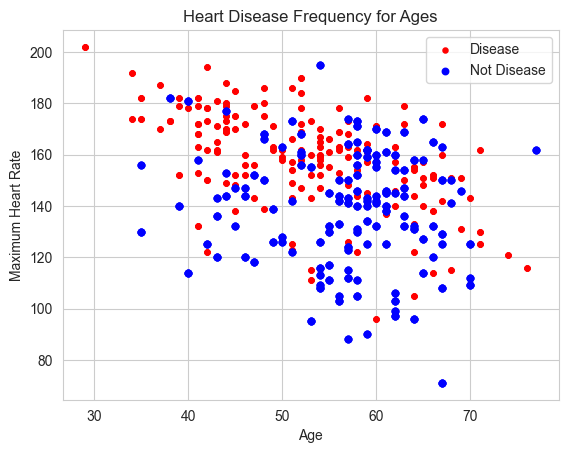

In [408]:
plot_data(data)


In [409]:
# Standardize the data.
X, y = standardize(data)

# Check that the data is normalized.
print("X means: ", np.mean(X) )
print("X stds: ", np.std(X) )

# Make a copy of y and change values from 0 to -1
y_copy = y.copy()
y_copy[y_copy == 0] = -1


train_x, test_x, train_y, test_y = train_test_split(X, y_copy, test_size=0.3)

X means:  -0.001486728597689243
X stds:  0.9906315622032373


# AdaBoost

In [410]:


# Calling the model Adaboost that we created
clf = Adaboost(n_clf = 50)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
# print(y_pred)
acc = accuracy_score(test_y, y_pred) * 100
print("Test Accuracy of Adaboost Algorithm: {:.2f}%".format(acc))


# Built-in AdaBoost
clf_sklearn = AdaBoostClassifier(n_estimators=50)
clf_sklearn.fit(train_x, train_y)
y_pred_sklearn = clf_sklearn.predict(test_x)

# print(y_pred_sklearn)
acc_sklearn = accuracy_score(test_y, y_pred_sklearn)

print("sklearn AdaBoost Accuracy:", acc_sklearn)
accuracies={}
accuracies['Adaboost'] = acc


  

Test Accuracy of Adaboost Algorithm: 80.19%
sklearn AdaBoost Accuracy: 0.8733766233766234


# SVM

In [411]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(train_x, train_y)

acc = svm.score(train_x, train_y)*100
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))

Test Accuracy of SVM Algorithm: 94.98%


# Logistic Regression

In [412]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_x,train_y)
accuracy = lr.score(test_x,test_y)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy of Logistic Regression Algorithm {:.2f}%".format(accuracy))

Test Accuracy of Logistic Regression Algorithm 82.79%


## Compare our results to Logistic Regression && SVM

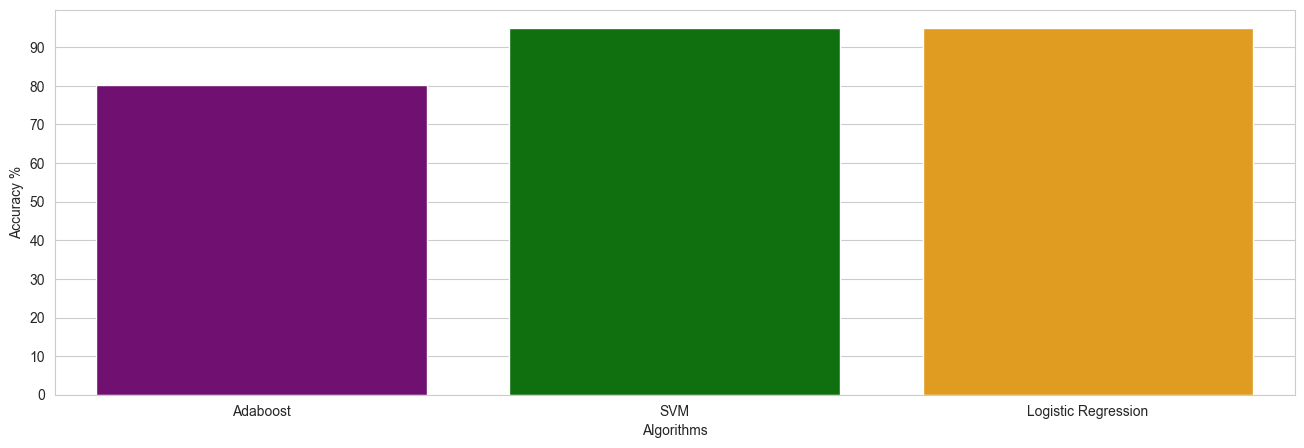

In [413]:
import seaborn as sns
colors = ["purple", "green", "orange"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()